<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 08 &mdash; Asset Allocation**

&copy; Dr. Yves J. Hilpisch

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

## Capital Market Line

In [1]:
!git clone https://github.com/tpq-classes/rl_4_finance.git
import sys
sys.path.append('rl_4_finance')


Cloning into 'rl_4_finance'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 72 (delta 47), reused 47 (delta 32), pack-reused 0 (from 0)
Receiving objects: 100% (72/72), 109.46 KiB | 2.10 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [2]:
import math
import random
import numpy as np
import pandas as pd
from scipy import stats
from pylab import plt, mpl

In [3]:
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%config InlineBackend.figure_format = 'svg'

In [4]:
r = 0.025  # <1>
beta = 0.2  # <2>
sigma = 0.375  # <3>
mu = r + beta * sigma  # <4>
mu  # <4>

0.1

In [5]:
vol = np.linspace(0, 0.5)  # <5>
ret = r + beta * vol  # <5>

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-1103871631.py:8: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xticklabels((0, '$\sigma$',))
/tmp/ipython-input-1103871631.py:10: SyntaxWarning: invalid escape sequence '\m'
  ax.set_yticklabels((0, '$r$', '$\mu$'))


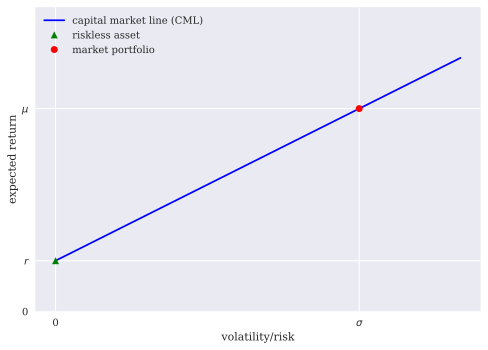

In [6]:
fig, ax = plt.subplots()
plt.plot(vol, ret, 'b', label='capital market line (CML)')
plt.plot(0, r, 'g^', label='riskless asset')
plt.plot(sigma, mu, 'ro', label='market portfolio')
plt.xlabel('volatility/risk')
plt.ylabel('expected return')
ax.set_xticks((0, sigma))
ax.set_xticklabels((0, '$\sigma$',))
ax.set_yticks((0, r, mu))
ax.set_yticklabels((0, '$r$', '$\mu$'))
plt.ylim(0, 0.15)
plt.legend();

## Investing Environment

In [7]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)

In [8]:
class action_space:
    def __init__(self, n):
        self.n = n

    def seed(self, seed):
        random.seed(seed)

    def sample(self):
        return random.random()  # <1>

In [9]:
class Investing:
    def __init__(self, S0, T, r_, mu_, sigma_, steps, amount):
        self.initial_value = S0
        self.maturity = T
        self.short_rate_ = r_  # <1>
        self.index_drift_ = mu_  # <1>
        self.volatility_ = sigma_  # <1>
        self.steps = steps
        self.initial_balance = amount  # <2>
        self.portfolio_value = amount  # <3>
        self.portfolio_value_new = amount  # <4>
        self.observation_space = observation_space(4)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(1)
        self._generate_data()
        self.portfolios = pd.DataFrame()
        self.episode = 0

In [10]:
class Investing(Investing):
    def _generate_data(self):
        s = [self.initial_value]
        self.short_rate = random.choice(self.short_rate_)  # <1>
        self.index_drift = random.choice(self.index_drift_)  # <1>
        self.volatility = random.choice(self.volatility_)  # <1>
        self.dt = self.maturity / self.steps
        for t in range(1, self.steps + 1):
            st = s[t - 1] * math.exp(
                (self.index_drift * self.dt +
                  self.volatility * math.sqrt(self.dt) * random.gauss(0, 1))
            )  # <2>
            s.append(st)
        self.data = pd.DataFrame(s, columns=['Xt'])
        self.data['Yt'] = self.initial_value * np.exp(
            self.short_rate * np.arange(len(self.data)) * self.dt)  # <3>

In [11]:
class Investing(Investing):
    def _get_state(self):
        Xt = self.data['Xt'].iloc[self.bar]
        Yt = self.data['Yt'].iloc[self.bar]
        return np.array([Xt, Yt, self.xt, self.yt]), {}

    def seed(self, seed=None):
        if seed is not None:
            random.seed(seed)

    def reset(self):
        self.bar = 0
        self.yt = 0
        self.xt = 0
        self.treward = 0
        self.portfolio_value = self.initial_balance
        self.portfolio_value_new = self.initial_balance
        self.episode += 1
        self._generate_data()
        self.state, _ = self._get_state()
        return self.state, _

In [12]:
class Investing(Investing):
    def add_results(self, pl):
        df = pd.DataFrame({'e': self.episode, 'xt': self.xt,
                   'yt': self.yt, 'pv': self.portfolio_value,
                   'pv_new': self.portfolio_value_new, 'p&l[$]': pl,
                   'p&l[%]': pl / self.portfolio_value_new,
                   'Xt': self.state[0],  'Yt': self.state[1],
                   'Xt_new': self.new_state[0],
                   'Yt_new': self.new_state[1],
                   'r': self.short_rate, 'mu': self.index_drift,
                   'sigma': self.volatility}, index=[0])
        self.portfolios = pd.concat((self.portfolios, df),
                                    ignore_index=True)

    def step(self, action):
        self.bar += 1
        self.new_state, _ = self._get_state()
        if self.bar == 1:  # <1>
            self.xt = action # <2>
            self.yt = (1 - action) # <3>
            pl = 0.
            reward = 0.
            self.add_results(pl)
        else:
            self.portfolio_value_new = (
                self.xt * self.portfolio_value *
                self.new_state[0] / self.state[0] +
                self.yt * self.portfolio_value *
                self.new_state[1] / self.state[1])  # <4>
            pl = self.portfolio_value_new - self.portfolio_value  # <5>
            self.xt = action # <6>
            self.yt = (1 - action) # <7>
            self.add_results(pl)  # <8>
            reward = pl  # <9>
            self.portfolio_value = self.portfolio_value_new  # <10>
        if self.bar == len(self.data) - 1:
            done = True
        else:
            done = False
        self.state = self.new_state
        return self.state, reward, done, False, {}

In [13]:
S0 = 1.

In [14]:
investing = Investing(S0=S0, T=1.0, r_=[0.05], mu_=[0.3],
              sigma_=[0.35], steps=252, amount=1)

In [15]:
investing.seed(750)

In [16]:
investing._generate_data()

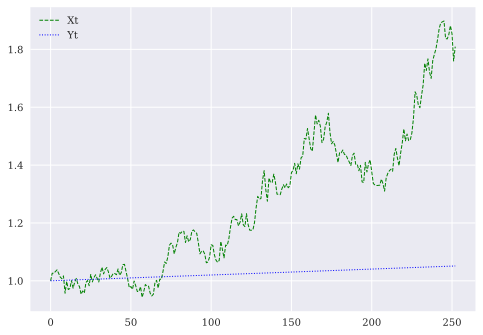

In [17]:
investing.data.plot(style=['g--', 'b:'], lw=1.0);

In [18]:
investing.reset()

(array([1., 1., 0., 0.]), {})

In [19]:
for _ in range(investing.steps - 1):
    investing.step(investing.action_space.sample())  # random agent

In [20]:
investing.portfolios.head().round(3)

,e,xt,yt,pv,pv_new,p&l[$],p&l[%],Xt,Yt,Xt_new,Yt_new,r,mu,sigma
0,1,0.587,0.413,1.000,1.000,0.000,0.000,1.000,1.000,0.980,1.000,0.050,0.300,0.350
1,1,0.001,0.999,1.000,1.009,0.009,0.009,0.980,1.000,0.994,1.000,0.050,0.300,0.350
2,1,0.838,0.162,1.009,1.009,0.000,0.000,0.994,1.000,0.974,1.001,0.050,0.300,0.350
3,1,0.981,0.019,1.009,0.998,-0.011,-0.011,0.974,1.001,0.962,1.001,0.050,0.300,0.350
4,1,0.167,0.833,0.998,0.979,-0.020,-0.020,0.962,1.001,0.943,1.001,0.050,0.300,0.350


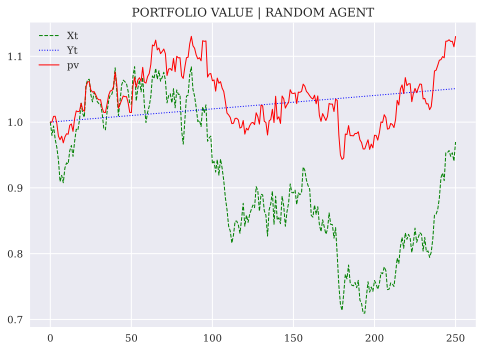

In [21]:
investing.portfolios[['Xt', 'Yt', 'pv']].plot(
    title='PORTFOLIO VALUE | RANDOM AGENT',
    style=['g--', 'b:', 'r-'], lw=1);

In [22]:
import os
import warnings
warnings.simplefilter('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [23]:
from dqlagent import *

In [24]:
opt = tf.keras.optimizers.Adam

In [25]:
class InvestingAgent(DQLAgent):
    def _create_model(self, hu, lr):
        self.model = Sequential()
        self.model.add(Dense(hu, input_dim=self.n_features,
                        activation='relu'))
        self.model.add(Dense(hu, activation='relu'))
        self.model.add(Dense(1, activation='linear'))  # <1>
        self.model.compile(loss='mse',
                optimizer=opt(learning_rate=lr))

In [26]:
from scipy.optimize import minimize

In [27]:
class InvestingAgent(InvestingAgent):
    def opt_action(self, state):
        bnds = [(0, 1)]  # <1>
        def f(state, x):  # <2>
            s = state.copy()
            s[0, 2] = x  # <3>
            s[0, 3] = 1 - x  # <4>
            return self.model(tf.convert_to_tensor(s, dtype=tf.float32), training=False).numpy()[0, 0]  # <5>
        action = minimize(lambda x: -f(state, x), 0.5,
                          bounds=bnds, method='Powell',options={"maxiter": 20})['x'][0]  # <6>
        return action

    def act(self, state):
        if random.random() <= self.epsilon:
            return self.env.action_space.sample()
        action = self.opt_action(state)  # <7>
        return action

In [28]:
#class InvestingAgent(InvestingAgent):
#    def replay(self):
#        batch = random.sample(self.memory, self.batch_size)
#        for state, action, next_state, reward, done in batch:
#            if not done:
#                action = self.opt_action(next_state)  # <1>
#                next_state[0, 2] = action  # <2>
#                next_state[0, 3] = 1 - action  # <3>
#                reward += (self.gamma *
#                    self.model.predict(next_state)[0, 0])  # <4>
#            reward = np.array([reward])
#            self.model.fit(state, reward, epochs=1,
#                           verbose=False)
#        if self.epsilon > self.epsilon_min:
#            self.epsilon *= self.epsilon_decay

In [29]:
class InvestingAgent(InvestingAgent):
    def replay(self):
        batch = random.sample(self.memory, self.batch_size)

        states      = np.vstack([b[0] for b in batch]).astype(np.float32)
        actions     = np.array([b[1] for b in batch], dtype=np.int32)
        next_states = np.vstack([b[2] for b in batch]).astype(np.float32)
        rewards     = np.array([b[3] for b in batch], dtype=np.float32)
        dones       = np.array([b[4] for b in batch], dtype=np.bool_)

        # Q(s, :)
        q_states = self.model(states, training=False).numpy()          # (B, A)

        # max_a' Q(s', a')
        q_next = self.model(next_states, training=False).numpy()       # (B, A)
        max_q_next = np.max(q_next, axis=1)                            # (B,)

        targets = q_states.copy()
        targets[np.arange(self.batch_size), actions] = rewards + self.gamma * max_q_next * (~dones)

         # One update only (FAST)
        self.model.train_on_batch(states, targets)
        #for state, action, next_state, reward, done in batch:
        #    if not done:
        #        action = self.opt_action(next_state)  # <1>
        #        next_state[0, 2] = action  # <2>
        #        next_state[0, 3] = 1 - action  # <3>
        #        reward += (self.gamma *
        #            self.model(tf.convert_to_tensor(next_state, dtype=tf.float32), training=False).numpy()[0, 0])  # <4>
        #    reward = np.array([reward])
        #    self.model.fit(state, reward, epochs=1,
        #                   verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [30]:
class InvestingAgent(InvestingAgent):
    def test(self, episodes, verbose=True):
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for _ in range(1, len(self.env.data) + 1):
                action = self.opt_action(state)
                state, reward, done, trunc, _ = self.env.step(action)
                state = self._reshape(state)
                treward += reward
                if done:
                    templ = f'episode={e} | '
                    templ += f'total reward={treward:4.2f}'
                    if verbose:
                        print(templ, end='\r')
                    break

In [31]:
np.random.seed(100)
tf.random.set_seed(100)

In [32]:
investing = Investing(S0=S0, T=1.0, r_=[0, 0.025, 0.05],
              mu_=[0.05, 0.1, 0.15],
              sigma_=[0.1, 0.2, 0.3], steps=252, amount=1)

In [33]:
agent = InvestingAgent('2AC', feature=None, n_features=4,
                     env=investing, hu=24, lr=0.001)

In [34]:
episodes = 250

In [ ]:
%time agent.learn(episodes)

In [ ]:
agent.epsilon

In [ ]:
agent.env.portfolios = pd.DataFrame()

In [ ]:
%time agent.test(100)

In [ ]:
n = max(agent.env.portfolios['e']) - 2  # <1>

In [ ]:
res = agent.env.portfolios[agent.env.portfolios['e'] == n]
res.head()

In [ ]:
p = res.iloc[0][['r', 'mu', 'sigma']]

In [ ]:
t = f"r={p['r']} | mu={p['mu']} | sigma={p['sigma']}"

In [ ]:
res[['Xt', 'Yt', 'pv']].plot(
    title='PORTFOLIO VALUE | ' + t,
    style=['g--', 'b:', 'r-'], lw=1);

In [ ]:
rets = res[['Xt', 'Yt', 'pv']].pct_change().mean() / agent.env.dt  # <1>
rets

In [ ]:
stds = res[['Xt', 'Yt', 'pv']].pct_change(
    ).std() / math.sqrt(agent.env.dt)  # <2>
stds

In [ ]:
rets[['Xt', 'pv']] / stds[['Xt', 'pv']]  # <3>

In [ ]:
res['xt'].mean()  # <4>

In [ ]:
res['xt'].std()  # <5>

In [ ]:
res['xt'].plot(title='RISKY ALLOCATION | ' + t,
               lw=1.0, c='b')
plt.ylim(0.55, 0.7);

In [ ]:
agent.env.portfolios.groupby('mu')['xt'].describe()

In [ ]:
agent.env.portfolios.groupby('sigma')['xt'].describe()

In [ ]:
agent.env.portfolios.groupby('mu')['pv_new'].describe()

In [ ]:
agent.env.portfolios.groupby('sigma')['pv_new'].describe()

In [ ]:
n = max(agent.env.portfolios['e']) - 3  # <1>

In [ ]:
res = agent.env.portfolios[agent.env.portfolios['e'] == n]

In [ ]:
p = res.iloc[0][['r', 'mu', 'sigma']]

In [ ]:
t = f"r={p['r']} | mu={p['mu']} | sigma={p['sigma']}"

In [ ]:
res[['Xt', 'Yt', 'pv', 'xt']].plot(
    title='PORTFOLIO VALUE | ' + t,
    style=['g--', 'b:', 'r-', 'm-.'], lw=1,
    secondary_y='xt'
);

## Two Assets

In [ ]:
class Investing(Investing):
    def __init__(self, asset_one='.SPX', asset_two='.VIX',
                 steps=252, amount=1):
        self.asset_one = asset_one
        self.asset_two = asset_two
        self.steps = steps
        self.initial_balance = amount
        self.portfolio_value = amount
        self.portfolio_value_new = amount
        self.observation_space = observation_space(4)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(1)
        self.retrieved = False
        self._generate_data()
        self.portfolios = pd.DataFrame()
        self.episode = 0

    def _generate_data(self):
        if self.retrieved:
            pass
        else:
            url = 'https://certificate.tpq.io/rl4finance.csv'  # <1>
            self.raw = pd.read_csv(url, index_col=0,
                                   parse_dates=True).dropna()  # <2>
            self.retrieved = True
        self.data = pd.DataFrame()
        self.data['Xt'] = self.raw[self.asset_one]
        self.data['Yt'] = self.raw[self.asset_two]
        s = random.randint(self.steps, len(self.data))  # <3>
        self.data = self.data.iloc[s-self.steps:s]  # <4>
        self.data = self.data / self.data.iloc[0]  # <5>

In [ ]:
class Investing(Investing):
    def _get_state(self):
        Xt = self.data['Xt'].iloc[self.bar]
        Yt = self.data['Yt'].iloc[self.bar]
        self.date = self.data.index[self.bar]  # <1>
        return np.array([Xt, Yt, self.xt, self.yt]), {}

    def add_results(self, pl):
        df = pd.DataFrame({
               'e': self.episode, 'date': self.date,  # <2>
               'xt': self.xt, 'yt': self.yt,
               'pv': self.portfolio_value,
               'pv_new': self.portfolio_value_new, 'p&l[$]': pl,
               'p&l[%]': pl / self.portfolio_value_new * 100,
               'Xt': self.state[0],  'Yt': self.state[1],
               'Xt_new': self.new_state[0],
               'Yt_new': self.new_state[1],
                      }, index=[0])
        self.portfolios = pd.concat((self.portfolios, df),
                                    ignore_index=True)

In [ ]:
class Investing(Investing):
    def step(self, action):
        self.bar += 1
        self.new_state, info = self._get_state()
        if self.bar == 1:
            self.xt = action
            self.yt = (1 - action)
            pl = 0.
            reward = 0.
            self.add_results(pl)
        else:
            self.portfolio_value_new = (
                self.xt * self.portfolio_value *
                self.new_state[0] / self.state[0] +
                self.yt * self.portfolio_value *
                self.new_state[1] / self.state[1])
            pl = self.portfolio_value_new - self.portfolio_value
            pen = 2 * (self.xt - action) ** 2  # <1>
            self.xt = action
            self.yt = (1 - action)
            self.add_results(pl)
            ret = self.portfolios['p&l[%]'].iloc[-1] / 100 * 252  # <2>
            vol = self.portfolios['p&l[%]'].rolling(
                20, min_periods=1).std().iloc[-1] * math.sqrt(252)  # <3>
            sharpe = ret / vol # <4>
            reward = sharpe - pen  # <5>
            self.portfolio_value = self.portfolio_value_new
        if self.bar == len(self.data) - 1:
            done = True
        else:
            done = False
        self.state = self.new_state
        return self.state, reward, done, False, {}

In [ ]:
days = 2 * 252

In [ ]:
investing = Investing(asset_one='.SPX',
            asset_two='.VIX', steps=days)

In [ ]:
investing.data.head()

In [ ]:
investing.data.corr()  # <1>

In [ ]:
investing.data.plot(secondary_y='Yt', style=['b', 'g--'], lw=1);

In [ ]:
random.seed(100)
np.random.seed(100)
tf.random.set_seed(100)

In [ ]:
agent = InvestingAgent('2AC', feature=None, n_features=4,
                     env=investing, hu=24, lr=0.0005)

In [ ]:
episodes = 125

In [ ]:
%time agent.learn(episodes)

In [ ]:
agent.epsilon

In [ ]:
agent.env.portfolios = pd.DataFrame()

In [ ]:
%time agent.test(20)

In [ ]:
agent.env.portfolios['xt'].describe()

In [ ]:
n = max(agent.env.portfolios['e']) - 1

In [ ]:
res = agent.env.portfolios[agent.env.portfolios['e'] == n]

In [ ]:
res['xt'].plot(lw=1, c='b')
plt.ylim(res['xt'].min() - 0.1, res['xt'].max() + 0.1);

In [ ]:
res[['Xt', 'Yt', 'pv']].iloc[-1]

In [ ]:
r = np.log(res[['Xt', 'Yt', 'pv']] /
           res[['Xt', 'Yt', 'pv']].shift(1))

In [ ]:
rets = np.exp(r.mean() * 252) - 1
rets

In [ ]:
stds = r.std() * math.sqrt(252)
stds

In [ ]:
rets / stds

In [ ]:
res[['Xt', 'Yt', 'pv']].plot(
    title='PORTFOLIO VALUE',
    style=['g--', 'b:', 'r-'],
    lw=1, grid=True);

In [ ]:
values = agent.env.portfolios.groupby('e')[['Xt', 'Yt', 'pv']].last()
values.tail()

In [ ]:
((values['pv'] > values['Xt']) & (values['pv'] > values['Yt'])).all()

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>